In [1]:
import torch
import numpy as np
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = open('names.txt', 'r').read().splitlines()

In [3]:
names=[x.lower() for x in names]

In [4]:
names[:10]

['aamir',
 'aaron',
 'abbey',
 'abbie',
 'abbot',
 'abbott',
 'abby',
 'abdel',
 'abdul',
 'abdulkarim']

In [5]:
sums=0
for i in names:
    sums+=len(i)
sums/len(names)
#so avg len of all names is 6 

6.032729103726083

In [6]:
chars = sorted(list(set(''.join(names))))

In [7]:
#string to int ,int to string implementation
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)
print(len(itos))

{' ': 1, "'": 2, '-': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29, '.': 0}
30


In [8]:
context=3 #fom past how many char you want to predict next

In [9]:
def build_dataset(names):
    # create the dataset
    xs, ys = [], []
    for name in names:
      li=[]
      names='.'*context+name+'.'
      for i in names:
        li.append(stoi[i])
      con=li[:context]
      for i in range(len(name)+1):
            xs.append(con)
            ys.append(li[context+i])
            con=li[i+1:i+1+context]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs,ys

In [10]:
#spliting data set to train,validation,test
n1=int(len(names)*0.8)
n2=int(len(names)*0.9)
random.shuffle(names)
x_train,y_train =build_dataset(names[:n1])
x_vali,y_vali =build_dataset(names[n1:n2])
x_test,y_test =build_dataset(names[n2:])

In [11]:
#checking
for i in range(10):
    for j in range(len(x_train[i])):
           print([x_train[i][j].item()],end='')
    print([y_train[i].item()])

[0][0][0][6]
[0][0][6][11]
[0][6][11][21]
[6][11][21][12]
[11][21][12][22]
[21][12][22][23]
[12][22][23][4]
[22][23][4][5]
[23][4][5][8]
[4][5][8][15]


In [12]:
x_train.shape

torch.Size([44621, 3])

In [13]:
#init NN
#input is context*30 matrix , output of NN should be 30*1 prob scores
#using kaiming initilization
W1 = (torch.randn((context,100),dtype=torch.float32)*(1.66/context**(0.5))).requires_grad_()
W2 = (torch.randn((100,30),dtype=torch.float32)).requires_grad_()
b1=((torch.ones(100,dtype=torch.float32))*0.01).requires_grad_()
b2=((torch.ones(30,dtype=torch.float32))*0.01).requires_grad_()
parameters = [W1, b1, W2, b2]

In [14]:
sum(p.nelement() for p in parameters) # number of parameters in total

3430

In [15]:
y_train.shape

torch.Size([44621])

In [16]:
x_tr=x_train.float()
x_tr.shape

torch.Size([44621, 3])

In [17]:
for p in parameters:
    p.requires_grad = True

In [18]:
step=[]
lossi=[]
lr=0.001
epochs=200000
alpha=0.1

In [19]:
for k in range(epochs):
    ix = torch.randint(0,x_tr.shape[0], (256,)) # mini batch sample each time randomly of size 128(may result in some noice)
    #forward pass
    h = torch.tanh(x_tr[ix] @ W1 + b1) 
    logits = h @ W2 + b2 
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdims=True)
    loss = -prob[torch.arange(len(ix)), y_train[ix]].log().mean() + 0.1*(W1**2).mean()  #adding L2 regulalizer
   
    
    #backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    
    
    #update parameters
    if(k<100000):
        lr=0.1
    else:
        0.01
    for p in parameters:
        p.data-=lr*p.grad    #gradient descent update each time
       
    #for stats
    if(k%10000==0):
        print("Loss at iteration {}: {}".format(k, loss))
        lossi.append(loss.item())
        step.append(k)
    


Loss at iteration 0: 18.165739059448242
Loss at iteration 10000: 2.60614275932312
Loss at iteration 20000: 2.7658557891845703
Loss at iteration 30000: 2.7102296352386475
Loss at iteration 40000: 2.494450569152832
Loss at iteration 50000: 2.506091356277466
Loss at iteration 60000: 2.545497179031372
Loss at iteration 70000: 2.5056400299072266
Loss at iteration 80000: 2.5473663806915283
Loss at iteration 90000: 2.4196131229400635
Loss at iteration 100000: 2.702176570892334
Loss at iteration 110000: 2.552915334701538
Loss at iteration 120000: 2.462733030319214
Loss at iteration 130000: 2.452136754989624
Loss at iteration 140000: 2.4540791511535645
Loss at iteration 150000: 2.467728853225708
Loss at iteration 160000: 2.4484195709228516
Loss at iteration 170000: 2.443580389022827
Loss at iteration 180000: 2.4585494995117188
Loss at iteration 190000: 2.514302968978882


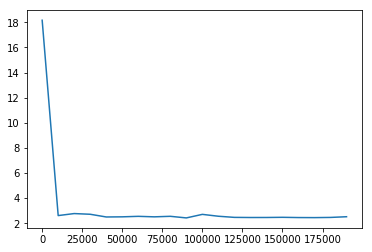

In [20]:
plt.plot(step,lossi)

In [35]:
#generate names from model
for i in range(10):
    res=[]
    con=[0]*context
    while True:
        h = torch.tanh(torch.tensor(con).float() @ W1 + b1) 
        logits = h @ W2 + b2 
        counts = logits.exp()
        prob = counts / counts.sum(-1, keepdims=True)
#         print(prob)
        ix = torch.multinomial(prob, num_samples=1).item()
        con=con[1:]
        con.append(ix)
        res.append(ix)
        if(ix==0):
            break
    print(''.join(itos[i] for i in res))
        

nerle.
viannier.
caleie.
dohciinilyeteda.
etona.
habyhls.
risfce.
revianyoiedabilolsthie.
adnbr.
mfr.


In [31]:
# TODO
# use batch normalization
# use validation set to set correct alpha and other hyper parameters